In [8]:
%%capture
%pip install dynamodb_json

In [9]:
import boto3
import pandas as pd
import seaborn as sns
import time
import sagemaker
from dynamodb_json import json_util
from datetime import timedelta

In [10]:
def transformDF(df, **kwargs):
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
    if 'df_type' in kwargs:
        if kwargs['df_type'] == 'true':
            df['Metric'] = 'true'
        elif kwargs['df_type'] == 'pred':        
            df['Timestamp'] = df['Timestamp']-timedelta(hours=8)
            df = df.drop('Id', axis=1)
    return df

In [11]:
def plotDF(df, category, **kwargs):
    mask_cat = df['Mt_category']==category
    if 'p' in kwargs:
        mask_p = df['Metric']==kwargs['p']
        mask = mask_cat & mask_p
    else:
        mask = mask_cat
    df_plot = df[mask]
    sns.lineplot(x='Timestamp', y='Value', data=df_plot)

In [12]:
def load_pred(table_name):
    client = boto3.client('dynamodb')
    results = []
    last_evaluated_key = None
    while True:
        if last_evaluated_key:
            response = client.scan(
                TableName=table_name,
                ExclusiveStartKey=last_evaluated_key
            )
        else: 
            response = client.scan(TableName=table_name)
        last_evaluated_key = response.get('LastEvaluatedKey')
        
        results.extend(response['Items'])
        
        if not last_evaluated_key:
            break
    return pd.DataFrame(json_util.loads(results))

In [13]:
def load_true(key_s, key_r):
    s3 = boto3.client('s3') 
    bucket_name = sagemaker.Session().default_bucket()
    obj_s = s3.get_object(Bucket=bucket_name, Key=key_s)
    obj_r = s3.get_object(Bucket=bucket_name, Key=key_r)
    df_s = pd.read_csv(obj_s['Body'], header=None, names=['Timestamp','Mt_category','Value'])
    df_r = pd.read_csv(obj_r['Body'], header=None, names=['Timestamp','Mt_category','Value'])
    return pd.concat([df_s, df_r])

In [ ]:
key_s = 'puretech_data/schedule-valid-combine.csv'
key_r = 'puretech_data/retry-valid-combine.csv'
df_true = load_true(key_s, key_r)
df_true=transformDF(df_true, df_type='true')
df_true.head()

In [ ]:
df_pred = load_pred('BillForecastCombine')
df_pred = transformDF(df_pred, df_type='pred')
df_pred.head()

In [15]:
df = pd.concat([df_pred, df_true])
df.head()

,Metric,Timestamp,Value,Mt_category
0,p50,2020-06-19 06:00:00,0.136945,schedule
1,p50,2020-06-19 07:00:00,0.162848,schedule
2,p50,2020-06-19 08:00:00,0.159363,schedule
3,p50,2020-06-19 09:00:00,0.174289,schedule
4,p50,2020-06-19 10:00:00,0.155467,schedule


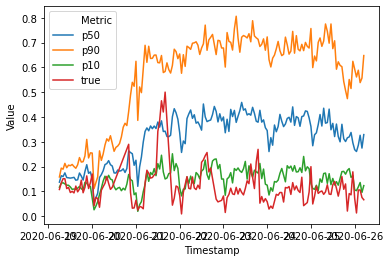

In [16]:
# Plot for one week
category = 'schedule'
mask1 = df.Mt_category==category
mask2 = df.Timestamp.isin(df_pred[df_pred.Mt_category==category].Timestamp)
mask = mask1&mask2
sns.lineplot(x='Timestamp', y='Value', hue='Metric', data=df[mask])

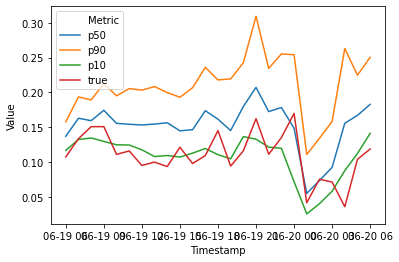

In [25]:
# Plot for one day
category = 'schedule'
mask1 = df.Mt_category==category
mask2 = df.Timestamp<= '2020-06-20 06:00:00'
mask = mask1&mask2
sns.lineplot(x='Timestamp', y='Value', hue='Metric', data=df[mask])

Insights: stacked algo. if >0.3, choose that day. If global max, choose that day.
Insight2: update forecast daily

In [ ]:
category = 'retry1'
mask1 = df.Mt_category==category
mask2 = df.Timestamp.isin(df_pred[df_pred.Mt_category==category].Timestamp)
mask = mask1&mask2
sns.lineplot(x='Timestamp', y='Value', hue='Metric', data=df[mask])

In [5]:
bucket_name = sagemaker.Session().default_bucket()
region = sagemaker.Session().boto_region_name
session = boto3.Session(region_name=region) 
forecast = session.client(service_name='forecast') 
forecastquery = session.client(service_name='forecastquery')
predictorArn_s='arn:aws:forecast:us-east-1:344055016255:predictor/bill_success_rate_combine_schedule_deepAR'
forecast.get_accuracy_metrics(PredictorArn=predictorArn_s)

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/Deep_AR_Plus',
   'TestWindows': [{'EvaluationType': 'SUMMARY',
     'Metrics': {'RMSE': 0.02665932768733433,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.18781557869113444},
       {'Quantile': 0.5, 'LossValue': 0.18404779243988267},
       {'Quantile': 0.1, 'LossValue': 0.0838254397190779}]}},
    {'TestWindowStart': datetime.datetime(2020, 6, 12, 6, 0, tzinfo=tzlocal()),
     'TestWindowEnd': datetime.datetime(2020, 6, 19, 6, 0, tzinfo=tzlocal()),
     'ItemCount': 1,
     'EvaluationType': 'COMPUTED',
     'Metrics': {'RMSE': 0.024328260090243033,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.0923963062788425},
       {'Quantile': 0.5, 'LossValue': 0.16119227140489975},
       {'Quantile': 0.1, 'LossValue': 0.07775565421513118}]}},
    {'TestWindowStart': datetime.datetime(2020, 5, 29, 6, 0, tzinfo=tzlocal()),
     'TestWindowEnd': datetime.datetim

In [6]:
predictorArn_r='arn:aws:forecast:us-east-1:344055016255:predictor/bill_success_rate_combine_retry_deepAR'
forecast.get_accuracy_metrics(PredictorArn=predictorArn_r)

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/Deep_AR_Plus',
   'TestWindows': [{'EvaluationType': 'SUMMARY',
     'Metrics': {'RMSE': 0.00531609606720877,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.09292250979305584},
       {'Quantile': 0.5, 'LossValue': 0.16239858231129},
       {'Quantile': 0.1, 'LossValue': 0.089529920584466}]}},
    {'TestWindowStart': datetime.datetime(2020, 6, 27, 16, 0, tzinfo=tzlocal()),
     'TestWindowEnd': datetime.datetime(2020, 6, 28, 16, 0, tzinfo=tzlocal()),
     'ItemCount': 1,
     'EvaluationType': 'COMPUTED',
     'Metrics': {'RMSE': 0.003462383530770398,
      'WeightedQuantileLosses': [{'Quantile': 0.9,
        'LossValue': 0.05924348529194383},
       {'Quantile': 0.5, 'LossValue': 0.1325645523527963},
       {'Quantile': 0.1, 'LossValue': 0.09668728322246858}]}},
    {'TestWindowStart': datetime.datetime(2020, 6, 28, 16, 0, tzinfo=tzlocal()),
     'TestWindowEnd': datetime.datetime

In [ ]:
df_pred